# Цилиндрическая панорама

В данном ноутбуке будут представлены все нужные функции, тесты для проверки написанных методов и общая структура решения, на каждом этапе которой будет визуализированы результаты работы с изображениями.

## Библиотеки

In [3]:
import plots

from skimage import io
import os
import numpy as np
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray
from skimage.transform import ProjectiveTransform
from skimage.transform import warp
from skimage.filters import gaussian
from numpy.linalg import inv

# Вспомогательные переменные
DEFAULT_TRANSFORM = ProjectiveTransform
test_dir = "./tests/01_unittest_ransac_input/"

## Part 0 

В данном фрагменте производится чтение кадров, вывод основных и показано их количество.

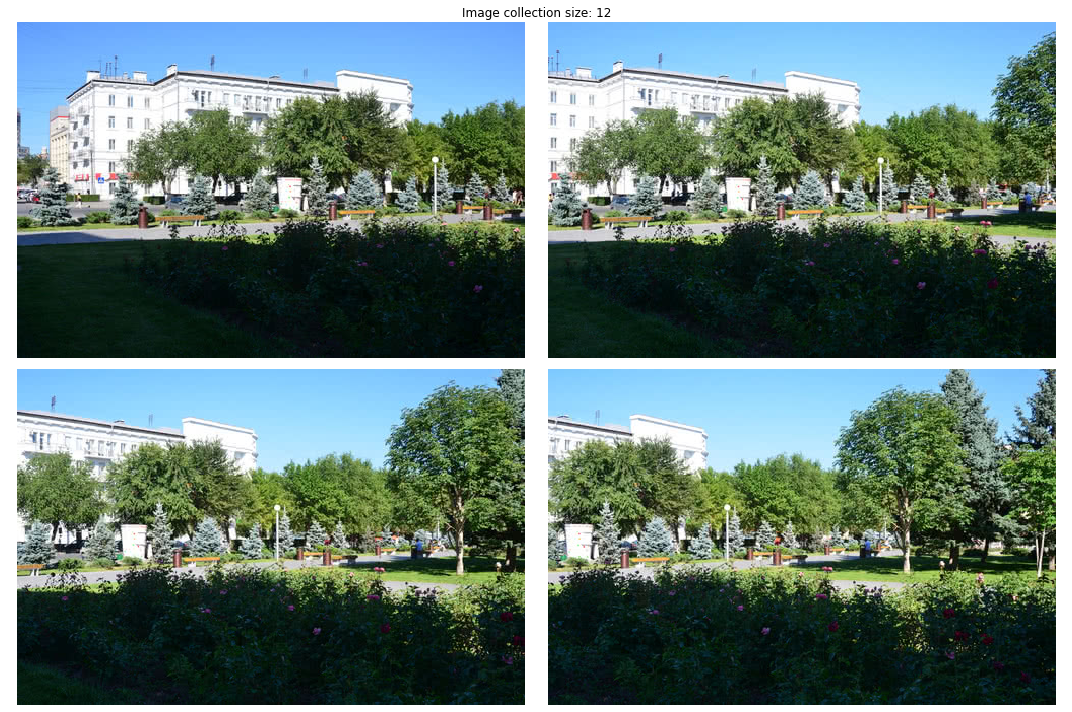

In [4]:
pano_image_collection = io.ImageCollection('imgs/00/8*.jpg',
                                           load_func=lambda f: io.imread(f).astype(np.float64) / 255)
plots.plot_collage(pano_image_collection, title=f"Image collection size: {len(pano_image_collection)}")


## Part 1

На данном этапе необходимо реализовать поиск ключевых точек на изображении. После работы метода приводится визуализация основных точек.

In [5]:
def find_orb(img, n_keypoints=1000):
    """Find keypoints and their descriptors in image.

    img ((W, H, 3)  np.ndarray) : 3-channel image
    n_keypoints (int) : number of keypoints to find

    Returns:
        (N, 2)  np.ndarray : keypoints
        (N, 256)  np.ndarray, type=np.bool  : descriptors
    """

    new_img = rgb2gray(img)
    #TODO: Свой код сюда
    descriptor = ORB(n_keypoints=n_keypoints)
    descriptor.detect_and_extract(new_img)
    
    return descriptor.keypoints, descriptor.descriptors

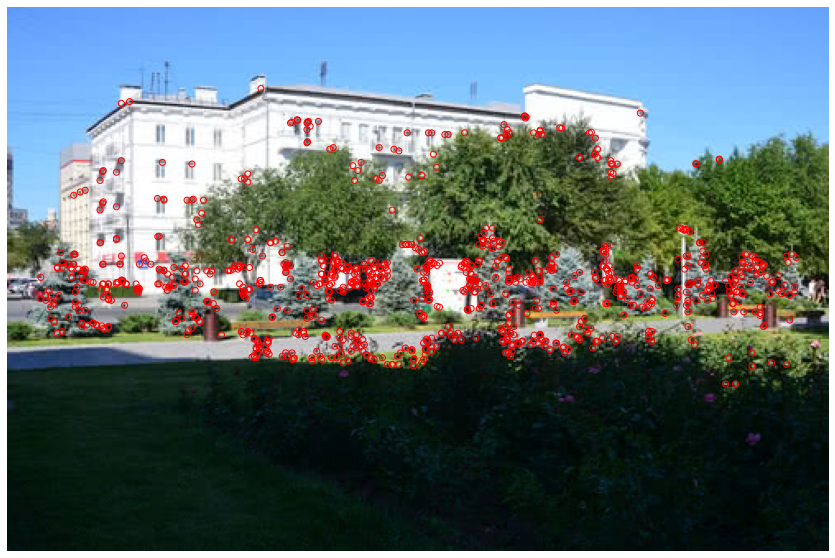

In [6]:
img = pano_image_collection[0]
keypoints, descriptors = find_orb(img)

# Визуализируем, что получается
plots.plot_keypoints(img, keypoints)

Проверьте, какие точки изображения выбраны - **соответствуют ли они углам и пятнам?**

## Part 2

На данном этапе надо реализовать центрирование и нормализацию кадров, затем реализовать поиск гомографии. После этого можно проверить реализацию функций тестами.

In [7]:
def center_and_normalize_points(points):
    """Center the image points, such that the new coordinate system has its
    origin at the centroid of the image points.

    Normalize the image points, such that the mean distance from the points
    to the origin of the coordinate system is sqrt(2).

    points ((N, 2) np.ndarray) : the coordinates of the image points

    Returns:
        (3, 3) np.ndarray : the transformation matrix to obtain the new points
        (N, 2) np.ndarray : the transformed image points
    """

    # Приводим точки к виду, нужному для гомографии -- x, y, 1
    pointsh = np.row_stack([points.T, np.ones((points.shape[0]), )]).astype(np.float64)

    # TODO: Посчитать середину кадра по оси X, Y
    C_x = np.mean(pointsh[0, :]).astype(np.float32)
    C_y = np.mean(pointsh[1, :]).astype(np.float32)
    
    # TODO: Посчитать нормировочную константу N
    N = np.sqrt(2)/np.mean(np.sqrt((points[0, :] - C_x) ** 2 + (points[1, :] - C_y) ** 2))

    # Собираем все значения в матрицу и возвращаем результат
    matrix = np.array([
        [N, 0, -N*C_x],
        [0, N, -N*C_y],
        [0, 0, 1]], dtype=np.float64)
    
    ortonorm_points = np.dot(matrix, pointsh).T[:, :2].astype(np.float64)
    
    return matrix, ortonorm_points


def find_homography(src_keypoints, dest_keypoints):
    """Estimate homography matrix from two sets of N (4+) corresponding points.

    src_keypoints ((N, 2) np.ndarray) : source coordinates
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates

    Returns:
        ((3, 3) np.ndarray) : homography matrix
    """

    # Приводим точки к единому виду
    src_matrix, src = center_and_normalize_points(src_keypoints)
    dest_matrix, dest = center_and_normalize_points(dest_keypoints)

    # Начальная инициализация матрицы гомографии
    H = np.zeros((3, 3))

    # Начальная инициализация матрицы A
    A = np.zeros((2*src_keypoints.shape[0], 9), dtype=np.float64)
    
    idx = 0
    for i in range(src_keypoints.shape[0]):
        # TODO: создать свои массивы, чтобы они заполняли матрицу A нужными значениями(между [] ввести по 9 элементов)
        a_x = np.array([-src[i, 0], -src[i, 1], -1, 0, 0, 0, src[i, 0]*dest[i, 0], src[i, 1]*dest[i, 0], dest[i, 0]], dtype=np.float64)
        a_y = np.array([0, 0, 0, -src[i, 0], -src[i, 1], -1, src[i, 0]*dest[i, 1], src[i, 1]*dest[i, 1], dest[i, 1]], dtype=np.float64)
        
        A[idx] = a_x
        A[idx+1] = a_y
        
        # Так как заполнили два элемента, то и шаг делаем 2
        idx += 2

    # Находим нужный нам вектор, используя сложную алгебру
    _, _, Vh = np.linalg.svd(A)
    H = Vh[-1]

    # Прерващаем вектор в матрицу и возвращаем результат
    H = H.reshape(3, 3)
    
    H = np.dot(np.linalg.inv(dest_matrix), np.dot(H, src_matrix)).astype(np.float64)
    return H

In [8]:
threshold = 1

----

### Test 1

Если ошибки не возникло и написано "ОК", то все ОК.

In [9]:
src_keypoints = np.array([[166, 220],
                        [213, 151],
                        [178, 392],
                        [158.4, 199.2],
                        [213, 185],
                        [204, 253]])

dest_keypoints = np.array([[165, 138],
                        [214, 66],
                        [178, 309],
                        [158.4, 116.4],
                        [214, 102],
                        [205, 171]])

H = find_homography(src_keypoints, dest_keypoints)

assert np.mean(np.linalg.norm(dest_keypoints - ProjectiveTransform(H)(src_keypoints), axis=1)) < threshold

print("OK")

OK


### Test 2

Если ошибки не возникло и написано "ОК", то все ОК.

In [10]:
src_keypoints = np.array([[1, 20],
                        [5, 5],
                        [15, 3],
                        [7, 14]])

dest_keypoints = np.array([[11, 2],
                        [25, 3],
                        [16, 13],
                        [8, 2]])

H = find_homography(src_keypoints, dest_keypoints)

assert np.mean(np.linalg.norm(dest_keypoints - ProjectiveTransform(H)(src_keypoints), axis=1)) < threshold

print("OK")

OK


### Test 3

Если ошибки не возникло и написано "ОК", то все ОК.

In [11]:
src_keypoints = np.array([[169. , 305. ],
   [223. , 412. ],
   [172. , 299. ],
   [ 98. , 219. ],
   [ 87. , 182. ],
   [ 79. , 330. ],
   [239. , 250. ],
   [172. , 304. ],
   [100. , 331. ],
   [226. , 323. ],
   [225. , 331. ],
   [278. , 215. ],
   [229. , 334. ],
   [221. , 258. ],
   [175.2, 156. ],
   [ 98. , 329. ],
   [232. , 293. ],
   [172. , 155. ],
   [144. , 245. ],
   [162. , 262. ],
   [229. , 315. ],
   [169. , 192. ],
   [196. , 351. ],
   [280. , 214. ],
   [225. , 186. ],
   [111. , 191. ],
   [223.2, 411.6],
   [166. , 193. ],
   [170.4, 304.8],
   [220. , 322. ],
   [226. , 216. ],
   [233. , 245. ],
   [199. , 244. ],
   [104. , 211. ],
   [171.6, 154.8],
   [261. , 474. ],
   [ 70. , 216. ],
   [223. , 252. ],
   [129. , 243. ],
   [187. , 280. ],
   [144. , 244.8],
   [ 74. , 203. ],
   [179. , 291. ],
   [222. , 335. ],
   [226. , 192. ],
   [175. , 445. ],
   [226. , 245. ],
   [ 79. , 206. ],
   [ 47. , 293. ],
   [144. , 139. ],
   [225. , 206. ],
   [171.6, 355.2],
   [178.8, 116.4],
   [218. , 444. ]])

dest_keypoints = np.array([[168. , 219. ],
   [221. , 323. ],
   [171. , 213. ],
   [ 97. , 133. ],
   [ 85. ,  95. ],
   [ 79. , 244. ],
   [239. , 163. ],
   [172. , 218. ],
   [100. , 245. ],
   [225. , 236. ],
   [224. , 244. ],
   [279. , 128. ],
   [228. , 247. ],
   [221. , 172. ],
   [175.2,  67.2],
   [ 98. , 243. ],
   [231. , 206. ],
   [172. ,  66. ],
   [143. , 159. ],
   [162. , 177. ],
   [228. , 228. ],
   [169. , 105. ],
   [195. , 264. ],
   [281. , 127. ],
   [226. ,  97. ],
   [110. , 104. ],
   [220.8, 322.8],
   [165. , 106. ],
   [169.2, 218.4],
   [219. , 235. ],
   [227. , 129. ],
   [233. , 159. ],
   [199. , 157. ],
   [103. , 125. ],
   [171.6,  66. ],
   [256. , 381. ],
   [ 68. , 130. ],
   [223. , 165. ],
   [128. , 157. ],
   [187. , 194. ],
   [144. , 158.4],
   [ 72. , 116. ],
   [178. , 205. ],
   [220. , 248. ],
   [227. , 104. ],
   [174. , 355. ],
   [226. , 158. ],
   [ 77. , 120. ],
   [ 46. , 208. ],
   [143. ,  49. ],
   [225. , 119. ],
   [170.4, 268.8],
   [178.8,  25.2],
   [215. , 353. ]])

H = find_homography(src_keypoints, dest_keypoints)

assert np.mean(np.linalg.norm(dest_keypoints - ProjectiveTransform(H)(src_keypoints), axis=1)) < threshold

print("OK")

OK


-----

## Part 3

В данном этапе необходимо для склейки изображений написать RANSAC-алгоритм. 

1. Изначально для пары изображений передаются особые точки и дескрипторы для пары кадров; 
2. Применяется RANSAC-алгоритм; 
3. Проверить его работу тестами;
4. Визуализируется результат стыковки особых точек.

In [12]:
src, dest = pano_image_collection[0], pano_image_collection[1]
src_keypoints, src_descriptors = find_orb(src)
dest_keypoints, dest_descriptors = find_orb(dest)

In [13]:
def ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, max_trials=500, residual_threshold=2, return_matches=False):
    """Match keypoints of 2 images and find ProjectiveTransform using RANSAC algorithm.

    src_keypoints ((N, 2) np.ndarray) : source coordinates
    src_descriptors ((N, 256) np.ndarray) : source descriptors
    dest_keypoints ((N, 2) np.ndarray) : destination coordinates
    dest_descriptors ((N, 256) np.ndarray) : destination descriptors
    max_trials (int) : maximum number of iterations for random sample selection.
    residual_threshold (float) : maximum distance for a data point to be classified as an inlier.
    return_matches (bool) : if True function returns matches

    Returns:
        skimage.transform.ProjectiveTransform : transform of source image to destination image
        (Optional)(N, 2) np.ndarray : inliers' indexes of source and destination images
    """

    # Выбрали сопоставления(отбросили выбросы) через библиотечную функцию, использовали ДЕСКРИПТОРЫ
    best_matches = match_descriptors(src_descriptors, dest_descriptors, cross_check=False)
    best_inliers = 0
     
    for i in range(max_trials):
        # 4 random elemetns
        copy_idxs = np.copy(np.arange(best_matches[:, 0].shape[0]))
        np.random.shuffle(copy_idxs)
        # TODO: выбрать СКОЛЬКО-ТО случайных точек(сколько - в лекции)
        chosen = copy_idxs[:4]

        # Выбираем по выбранным точкам соответствующие особенности каждого кадра
        src_chosen = src_keypoints[best_matches[chosen, 0]]
        dest_chosen = dest_keypoints[best_matches[chosen, 1]]
        
        # TODO: Строим матрицу гомографии для полученных пар(можно использовать функции, написанные ранее)
        H = find_homography(src_chosen, dest_chosen)
        
        # Преобразуем к нужному для гомографии виду - x, y, 1
        input_keypoints = np.row_stack([src_keypoints.T, np.ones((src_keypoints.shape[0]), )]).astype(np.float64)
        
        # TODO: Используя эти точки и построенную матрицу гомографии, построить предсказанные точки(результат отображения)
        predicted_keypoints = np.dot(H, input_keypoints)
        
        # Как обсуждалось, переходим к x', y', деля исходные на z.
        min_val = np.mean(predicted_keypoints[2][predicted_keypoints[2] != 0])
        predicted_keypoints[2][predicted_keypoints[2] == 0] = min_val
        predicted_keypoints[:2] = predicted_keypoints[:2]/predicted_keypoints[2]
        predicted_keypoints = predicted_keypoints[:2].T
        
        # TODO: Посчитаем расстояние от предсказанных до правильных точек
        # (Подсказка: в best_matches[:, 1] лежат индексы тех точек второго кадра(dest...), которым в соответствие поставлены predicted_keypoints)
        distances = np.linalg.norm(dest_keypoints[best_matches[:, 1]] - predicted_keypoints, axis=1)
        
        # Считаем, сколько хороших точек нашли
        cur_inliers = np.count_nonzero(distances<residual_threshold)
        
        # Если результат лучше, то обновляем рекорд
        if cur_inliers >= best_inliers:
            best_inliers = np.sum(distances<residual_threshold)
            best_result = best_matches[distances<residual_threshold]
            
    # Используя лучшую модель, строим отображение на данных, лишенных выбросов
    src = src_keypoints[best_result[:, 0]]
    dest = dest_keypoints[best_result[:, 1]]
    H = find_homography(src, dest)
    
    if return_matches:
        return ProjectiveTransform(H), best_result
    
    return ProjectiveTransform(H)

----

### Test 1

Если ошибки не возникло и написано "ОК", то все ОК.

In [14]:
data = np.load(os.path.join(test_dir, 'ransac_test1.npz'))
src_keypoints = data['src_k']
dest_keypoints = data['dest_k']
src_descriptors = data['src_d']
dest_descriptors = data['dest_d']
transform, matches = ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)
assert abs(len(matches) - len(src_keypoints)) < 3

print("OK")

OK


### Test 2

Если ошибки не возникло и написано "ОК", то все ОК.

In [15]:
threshold = 1.5
data = np.load(os.path.join(test_dir, 'ransac_test2.npz'))
src_keypoints = data['src_k']
dest_keypoints = data['dest_k']
src_descriptors = data['src_d']
dest_descriptors = data['dest_d']
print(type(dest_descriptors[0]))
transform, matches = ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)
assert np.mean(np.linalg.norm(dest_keypoints[matches[:, 1]] - transform(src_keypoints[matches[:, 0]]), axis=1)) < threshold

print("OK")

<class 'numpy.ndarray'>
OK


### Test 3

Если ошибки не возникло и написано "ОК", то все ОК.

In [19]:
threshold = 2.5
data = np.load(os.path.join(test_dir, 'ransac_test3.npz'))
src_keypoints = data['src_k']
dest_keypoints = data['dest_k']
src_descriptors = data['src_d']
dest_descriptors = data['dest_d']
print(type(dest_descriptors[0]))
transform, matches = ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)
assert np.mean(np.linalg.norm(dest_keypoints[matches[:, 1]] - transform(src_keypoints[matches[:, 0]]), axis=1)) < threshold

print("OK")


<class 'numpy.ndarray'>
OK


----

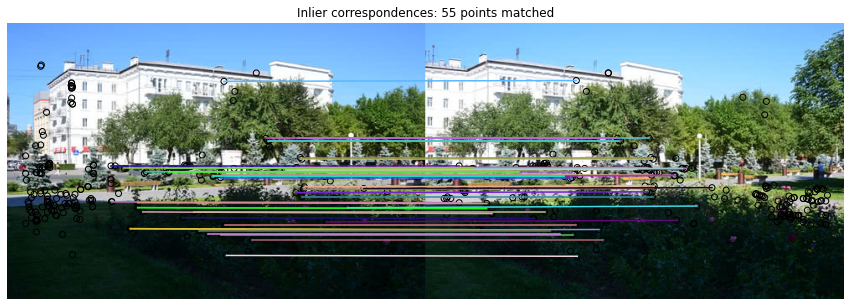

In [20]:
robust_transform, matches = ransac_transform(src_keypoints, src_descriptors, dest_keypoints, dest_descriptors, return_matches=True)

plots.plot_inliers(src, dest, src_keypoints, dest_keypoints, matches)

## Part 4

На данном этапе приводится визуализация отображения всех кадров на одну плоскость.

In [21]:
def find_simple_center_warps(forward_transforms):
    """Find transformations that transform each image to plane of the central image.

    forward_transforms (Tuple[N]) : - pairwise transformations

    Returns:
        Tuple[N + 1] : transformations to the plane of central image
    """
    image_count = len(forward_transforms) + 1
    center_index = (image_count - 1) // 2

    result = [None] * image_count
    result[center_index] = DEFAULT_TRANSFORM()

    # your code here
    for i in range(1, len(forward_transforms)//2 + 2):
        left_idx = center_index-i
        right_idx = center_index+i
        if left_idx >= 0:
            result[left_idx] = forward_transforms[left_idx]+result[left_idx+1]
        if right_idx < image_count:
            m = forward_transforms[right_idx-1]._inv_matrix
            result[right_idx] = ProjectiveTransform(m)+result[right_idx-1]
                
    return tuple(result)


def get_corners(image_collection, center_warps):
    """Get corners' coordinates after transformation."""
    for img, transform in zip(image_collection, center_warps):
        height, width, _ = img.shape
        corners = np.array([[0, 0],
                            [height, 0],
                            [height, width],
                            [0, width]])

        yield transform(corners)[:, ::-1]


def get_min_max_coords(corners):
    """Get minimum and maximum coordinates of corners."""
    corners = np.concatenate(corners)
    return corners.min(axis=0), corners.max(axis=0)


def get_final_center_warps(image_collection, simple_center_warps):
    """Find final transformations.

        image_collection (Tuple[N]) : list of all images
        simple_center_warps (Tuple[N])  : transformations unadjusted for shift

        Returns:
            Tuple[N] : final transformations
        """
    # your code here
    
    corners = tuple(get_corners(image_collection, simple_center_warps))
    
    corner_min, corner_max = get_min_max_coords(corners)
    output_shape = (corner_max-corner_min)
    output_shape = output_shape[::-1].astype(np.int32)
    
    H = np.array([
        [1, 0, -corner_min[1]],
        [0, 1, -corner_min[0]],
        [0, 0, 1]
    ], dtype=np.float64)
    
    
    adder = ProjectiveTransform(H)
    
    final_tranforms = [None] * len(simple_center_warps)
    for i in range(len(simple_center_warps)):
        final_tranforms[i] = simple_center_warps[i]+adder
        #final_tranforms[i] = adder+simple_center_warps[i]
        
    return tuple(final_tranforms), output_shape


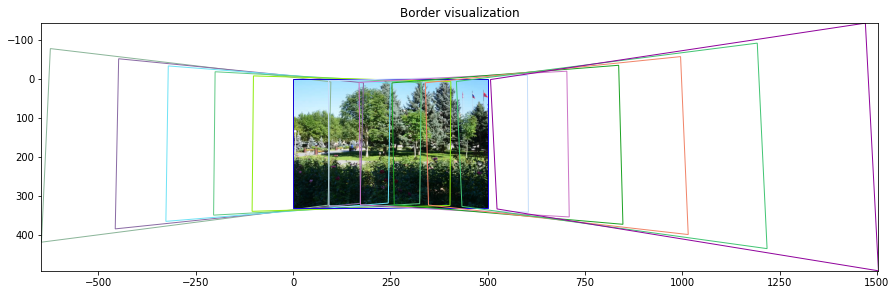

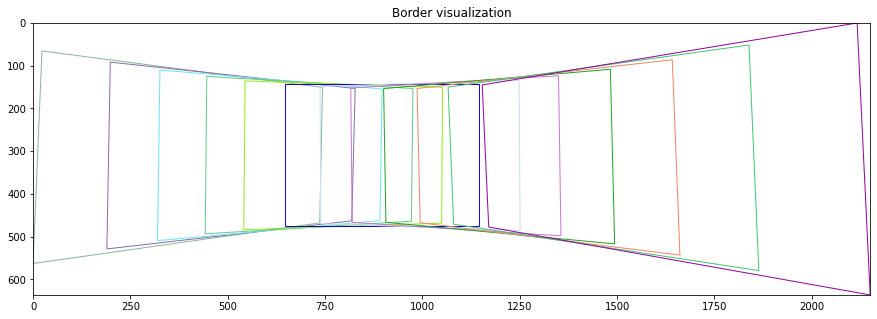

In [22]:
keypoints, descriptors = zip(*(find_orb(img) for img in pano_image_collection))
forward_transforms = tuple(ransac_transform(src_kp, src_desc, dest_kp, dest_desc)
                           for src_kp, src_desc, dest_kp, dest_desc
                           in zip(keypoints[:-1], descriptors[:-1], keypoints[1:], descriptors[1:]))


simple_center_warps = find_simple_center_warps(forward_transforms)
corners = tuple(get_corners(pano_image_collection, simple_center_warps))
min_coords, max_coords = get_min_max_coords(corners)
center_img = pano_image_collection[(len(pano_image_collection) - 1) // 2]

plots.plot_warps(corners, min_coords=min_coords, max_coords=max_coords, img=center_img)


final_center_warps, output_shape = get_final_center_warps(pano_image_collection, simple_center_warps)
corners = tuple(get_corners(pano_image_collection, final_center_warps))

plots.plot_warps(corners, output_shape=output_shape)

## Part 5

В данном фрагменте не полученные фрагменты накладываются кадры, т.е. заполняются рамки предыдущего этапа изображениями.

In [23]:
def rotate_transform_matrix(transform):
    """Rotate matrix so it can be applied to row:col coordinates."""
    matrix = transform.params[(1, 0, 2), :][:, (1, 0, 2)]
    return type(transform)(matrix)


def warp_image(image, transform, output_shape):
    """Apply transformation to an image and its mask

    image ((W, H, 3)  np.ndarray) : image for transformation
    transform (skimage.transform.ProjectiveTransform): transformation to apply
    output_shape (int, int) : shape of the final pano

    Returns:
        (W, H, 3)  np.ndarray : warped image
        (W, H)  np.ndarray : warped mask
    """
    # your code here
    
    new_img = warp(image, rotate_transform_matrix(transform).inverse, output_shape=output_shape)
    new_mask = warp(rgb2gray(image!=0), rotate_transform_matrix(transform).inverse, output_shape=output_shape).astype(np.bool8)
    
    return new_img, new_mask


def merge_pano(image_collection, final_center_warps, output_shape):
    """ Merge the whole panorama

    image_collection (Tuple[N]) : list of all images
    final_center_warps (Tuple[N])  : transformations
    output_shape (int, int) : shape of the final pano

    Returns:
        (output_shape) np.ndarray: final pano
    """
    result = np.zeros((output_shape[0], output_shape[1], 3))
    result_mask = np.zeros(output_shape, dtype=np.bool8)

    # your code here
    for i in range(len(image_collection)):
        new_img, new_mask = warp_image(image_collection[i], final_center_warps[i], output_shape)
        
        new_mask[result_mask==True] = False
        result_mask = result_mask + new_mask

        result[...,0] = result[...,0] + (new_img[...,0]*new_mask)
        result[...,1] = result[...,1] + (new_img[...,1]*new_mask)
        result[...,2] = result[...,2] + (new_img[...,2]*new_mask)

    return result

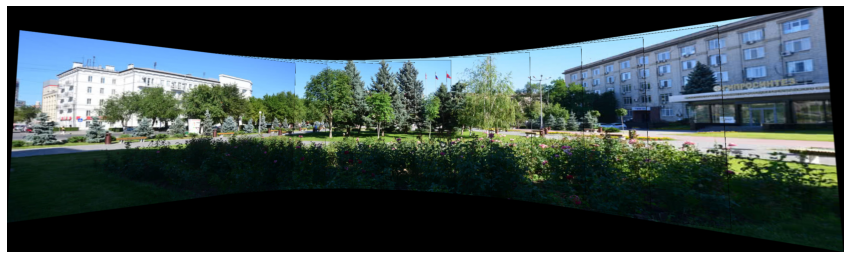

In [19]:
result = merge_pano(pano_image_collection, final_center_warps, output_shape)

plots.plot_result(result)

# Если хотите сохарнить результат, то раскомментируйте следующую строчку
#io.imsave('./results/base_pano.jpeg', result)

## Part 6

На этом этапе нужно реализовать пирамиды Лапласа и пирамиду Гаусса. После этого с использованием вспомогательных функций 

- визуализируется сначала исходное изображение; 
- потом результат склеивания пирамиды; 
- после этого показывается сама пирамида; 
- наконец, улучшение склейки с использованием пирамид.

In [24]:
def get_gaussian_pyramid(image, n_layers=5, sigma=10):
    """Get Gaussian pyramid.

    image ((W, H, 3)  np.ndarray) : original image
    n_layers (int) : number of layers in Gaussian pyramid
    sigma (int) : Gaussian sigma

    Returns:
        tuple(n_layers) Gaussian pyramid

    """
    
    pyramid = []
    for i in range(n_layers):
        # TODO: Заполнить пирамиду Гаусса, на первую позицию поставив исходное изображение, 
        # а на следующие - результат фильтра Гаусса к ПОСЛЕДНЕМУ заполненному элементу пирамиды
        # (т.е. на 2-ой итерации последним элементом будет исходное изображение, на 3-ей 2-ое изображение и тд)
        # Подсказка: применять фильтр Гаусса функцией gaussian(img, sigma)
        if i == 0:
            pyramid.append(image)
        else:
            tmp_image = gaussian(pyramid[-1], sigma)
            pyramid += [tmp_image]
            
    return tuple(pyramid)


def get_laplacian_pyramid(image, n_layers=4, sigma=2):
    """Get Laplacian pyramid

    image ((W, H, 3)  np.ndarray) : original image
    n_layers (int) : number of layers in Laplacian pyramid
    sigma (int) : Gaussian sigma

    Returns:
        tuple(n_layers) Laplacian pyramid
    """

    # Построим для изображений пирамиду Гаусса, о чем говорили в лекции
    pyramid_gauss = get_gaussian_pyramid(image, n_layers, sigma)
    pyramid = []
    for i in range(n_layers):
        # Поступаем, как и с пирамидой Гаусса, 
        # но в последний элемент кладем изображение с того же слоя пирамиды Гаусса,
        # а все предыдущие - разность элемента того же уровня пирамиды Гаусса и следующего
        if i < len(pyramid_gauss)-1:
            pyramid += [pyramid_gauss[i] - pyramid_gauss[i+1]]
        else:
            pyramid += [pyramid_gauss[-1]]
    return tuple(pyramid)


def merge_laplacian_pyramid(laplacian_pyramid):
    """Recreate original image from Laplacian pyramid

    laplacian pyramid: tuple of np.array (h, w, 3)

    Returns:
        np.array (h, w, 3)
    """
    return sum(laplacian_pyramid)# TODO: здесь нужно вернуть сумму всех элементов пирамиды Лапласа

In [25]:
def increase_contrast(image_collection):
    """Increase contrast of the images in collection"""
    result = []

    for img in image_collection:
        img = img.copy()
        for i in range(img.shape[-1]):
            img[:, :, i] -= img[:, :, i].min()
            img[:, :, i] /= img[:, :, i].max()
        result.append(img)

    return result


def gaussian_merge_pano(image_collection, final_center_warps, output_shape, n_layers=4, image_sigma=1, merge_sigma=5):
    """ Merge the whole panorama using Laplacian pyramid

    image_collection (Tuple[N]) : list of all images
    final_center_warps (Tuple[N])  : transformations
    output_shape (int, int) : shape of the final pano
    n_layers (int) : number of layers in Laplacian pyramid
    image_sigma (int) :  sigma for Gaussian filter for images
    merge_sigma (int) : sigma for Gaussian filter for masks

    Returns:
        (output_shape) np.ndarray: final pano
    """
    # your code here
    result = np.zeros((output_shape[0], output_shape[1], 3))
    result_mask = np.zeros(output_shape, dtype=np.float64)

    # your code here
    
    masks = [None] * len(image_collection)
    frames = [None] * len(image_collection)
    
    for i in range(len(image_collection)):
        new_img, new_mask = warp_image(image_collection[i], final_center_warps[i], output_shape)
    
        masks[i] = new_mask
        frames[i] = new_img
    
    corners = tuple(get_corners(image_collection, final_center_warps))
    for i in range(len(image_collection)-1):
        left_corner = int((corners[i][2, 0] + corners[i][3, 0])/2)
        right_corner = int((corners[i+1][0, 0] + corners[i+1][1, 0])/2)
        
        center = int((right_corner+left_corner)//2)
        masks[i][:, center:] = 0.
        masks[i+1][:, :center] = 0.
        
    #pyramids
    gausses = [None] * len(image_collection)
    for i in range(len(image_collection)):
        gausses[i] = get_gaussian_pyramid(masks[i], n_layers, merge_sigma)
    
    gausses = np.asarray(gausses, dtype = np.float64)
    #normilize
    
    for k in range(n_layers):
        tmp = np.zeros(output_shape, dtype=np.float64)
        tmp = np.sum(gausses[:, k], axis=0)
        tmp[tmp==0] = 1.0
        gausses[:, k] = gausses[:, k]/tmp
        
    #image transformation
    laplaces = [None] * len(image_collection)
    for i in range(len(image_collection)):
        laplaces[i] = get_laplacian_pyramid(frames[i], n_layers, image_sigma) 
        
    laplaces = np.asarray(laplaces, dtype=np.float64)
    
    result = np.zeros((output_shape[0], output_shape[1], 3), dtype=np.float64)
    for k in range(result.shape[-1]):
        for i in range(len(image_collection)):
            for l in range(n_layers):
                result[..., k] += laplaces[i, l][...,k]*gausses[i, l]
    
    return result

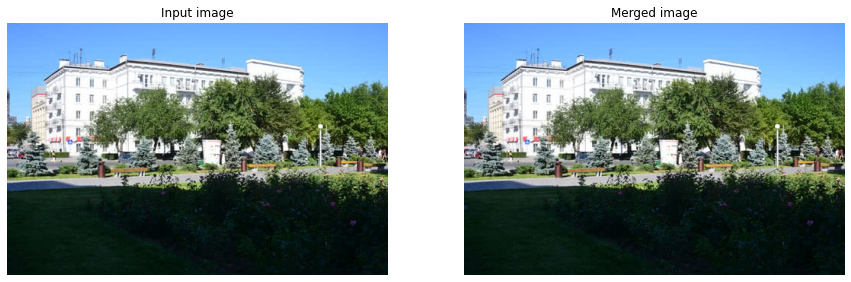

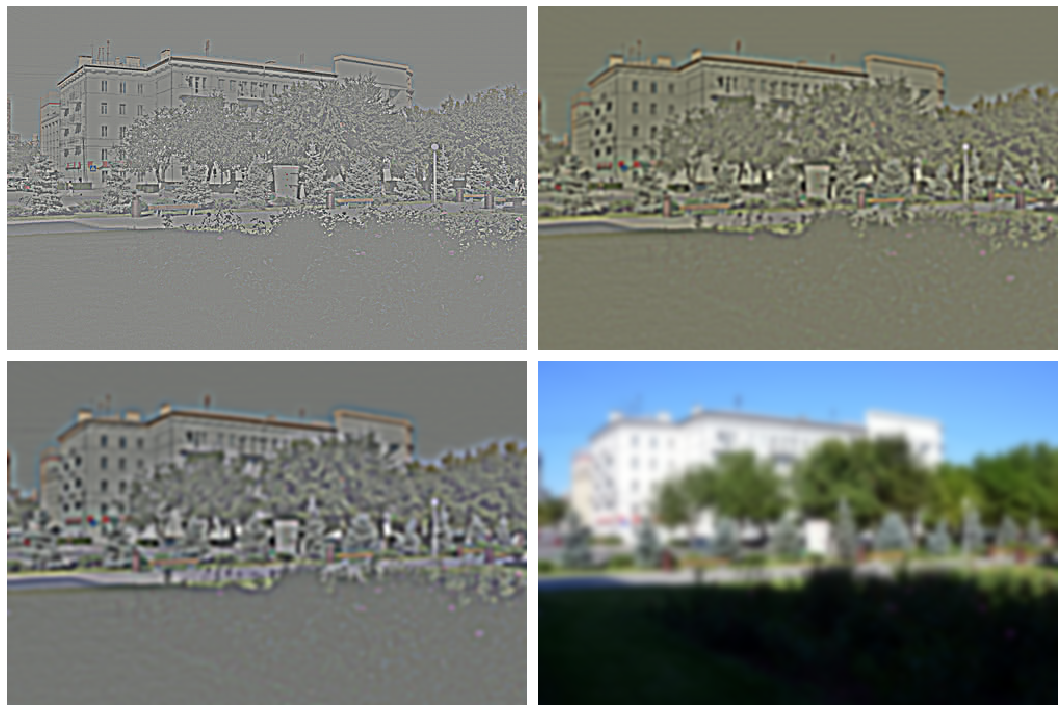

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


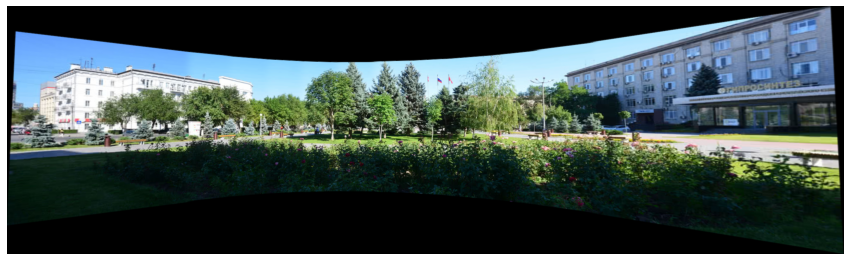

Lossy conversion from float64 to uint8. Range [-0.047157847331323874, 1.132864120108622]. Convert image to uint8 prior to saving to suppress this warning.


In [27]:
img = pano_image_collection[0]

laplacian_pyramid = get_laplacian_pyramid(img)
merged_img = merge_laplacian_pyramid(laplacian_pyramid)

plots.plot_gauss(img, merged_img)
plots.plot_collage(increase_contrast(laplacian_pyramid), columns=2, rows=2)

result = gaussian_merge_pano(pano_image_collection, final_center_warps, output_shape)

plots.plot_result(result)
io.imsave('./results/improved_pano.jpeg', result)

## Part 7 

На данном этапе приводится визуализация отображения из цилиндрического изображения в плоское.

In [28]:
def cylindrical_inverse_map(coords, h, w, scale):
    """Function that transform coordinates in the output image
    to their corresponding coordinates in the input image
    according to cylindrical transform.

    Use it in skimage.transform.warp as `inverse_map` argument

    coords ((M, 2) np.ndarray) : coordinates of output image (M == col * row)
    h (int) : height (number of rows) of input image
    w (int) : width (number of cols) of input image
    scale (int or float) : scaling parameter

    Returns:
        (M, 2) np.ndarray : corresponding coordinates of input image (M == col * row) according to cylindrical transform
    """
    # your code here
    
    K = np.array([
        [scale, 0, w/2],
        [0, scale, h/2],
        [0, 0, 1]
    ], dtype=np.float64)
    
    coords = np.row_stack([coords.T, np.ones(h*w), ]).astype(np.float64)
    new_coords = np.dot(inv(K), coords)
    
    B_x = np.tan(new_coords[0])
    B_y = new_coords[1]/(np.cos(new_coords[0]))
    
    B_tilda = np.row_stack([B_x, B_y, np.ones((h*w), )]).astype(np.float64)
    
    B = np.dot(K, B_tilda)[:2].T
    
    return B

def warp_cylindrical(img, scale=None, crop=True):
    """Warp image to cylindrical coordinates

    img ((H, W, 3)  np.ndarray) : image for transformation
    scale (int or None) : scaling parameter. If None, defaults to W * 0.5
    crop (bool) : crop image to fit (remove unnecessary zero-padding of image)

    Returns:
        (H, W, 3)  np.ndarray : warped image (H and W may differ from original)
    """
    # your code here
    if scale is None:
        scale = img.shape[1]*0.5
    
    H, W = img.shape[:2]
    
    new_img = warp(img, cylindrical_inverse_map, map_args={'h': H, 'w': W, 'scale': scale}, output_shape=img.shape)
    
    if crop:
        f_row = 0
        l_row = new_img.shape[0]
        for i in range(new_img.shape[0]):
            if new_img[i].sum() == 0:
                f_row = i
            else:
                break
        
        for i in range(new_img.shape[0]-1, -1, -1):
            if new_img[i].sum() == 0:
                l_row = i
            else:
                break
        
        f_col = 0
        l_col = new_img.shape[1]
        
        for i in range(new_img.shape[1]):
            if new_img[:, i, :].sum() == 0:
                f_col = i
            else:
                break
        
        for i in range(new_img.shape[1]-1, -1, -1):
            if new_img[:, i, :].sum() == 0:
                l_col = i
            else:
                break
        
        new_img = new_img[f_row: l_row, f_col: l_col, :]
        
    return new_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


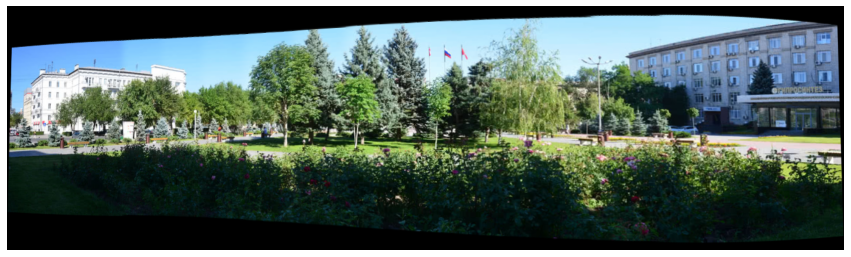

Lossy conversion from float64 to uint8. Range [-0.003808839852470751, 1.0864573465399823]. Convert image to uint8 prior to saving to suppress this warning.


In [29]:
cylindrical = warp_cylindrical(result, scale=result.shape[1]/np.pi)

plots.plot_result(cylindrical)
io.imsave('./results/cylindrical_pano.jpeg', cylindrical)